<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate Model training and adversarial training using ART on the Adults dataset.

Sensitivity to training set details:

https://nbviewer.jupyter.org/github/ageron/handson-ml2/blob/master/06_decision_trees.ipynb


https://github.com/rasbt/stat451-machine-learning-fs20


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Exploratory Data Analysis](#eda)
2.  [Data scale, Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [1]:
#!pip install mlxtend
#!pip install watermark

In [2]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend

Habtamu desalegn 
last updated: 2020-11-21 

CPython 3.8.3
IPython 7.18.1

numpy 1.19.4
pandas 1.1.3
scipy 1.4.1
matplotlib 3.3.2
sklearn 0.23.2
mlxtend 0.17.3


In [3]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions

#### Loading the IRIS dataset

In [4]:
""" UCI Adult Dataset (1994 Census)
    https://archive.ics.uci.edu/ml/machine-learning-databases/adult
    features: 14
    examples: 48842
feature type: categorical and numerical
        task: predict wheather a person makes above 50k a year
"""

COLUMNS = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                 "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
                 "hours-per-week", "native-country", "income"]
# PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
# df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)

df = pd.read_csv('./data/adult.csv', index_col=None)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

new_df = df.loc[:, ~df.columns.isin(['workclass','occupation','native-country'])]
new_df.loc[:,'education'] = le.fit_transform(new_df.loc[:,'education'].values)
new_df.loc[:,'marital-status'] = le.fit_transform(new_df.loc[:,'marital-status'].values)
new_df.loc[:,'relationship'] = le.fit_transform(new_df.loc[:,'relationship'].values)
new_df.loc[:,'race'] = le.fit_transform(new_df.loc[:,'race'].values)
new_df.loc[:,'sex'] = le.fit_transform(new_df.loc[:,'sex'].values)
new_df.loc[:,'income'] = le.fit_transform(new_df.loc[:,'income'].values)



In [7]:
new_df.head()

,age,fnlwgt,education,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,39,77516,9,13,4,1,4,1,2174,0,40,0
1,50,83311,9,13,2,0,4,1,0,0,13,0
2,38,215646,11,9,0,1,4,1,0,0,40,0
3,53,234721,1,7,2,0,2,1,0,0,40,0
4,28,338409,9,13,2,5,2,0,0,0,40,0


In [8]:
X = new_df.drop('income', axis=1).values
y = new_df['income'].values

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [10]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (22792, 11)
y_train.shape: (22792,)
X_test.shape: (9769, 11)
y_test.shape: (9769,)


<a id="eda"></a>
## 2. Exploratory Data Analysis

In [11]:
mean = new_df.groupby(['income']).mean()
mean

,age,fnlwgt,education,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week
income,,,,,,,,,,,
0,36.783738,190340.86517,10.125324,9.595065,2.780906,1.673422,3.631513,0.611974,148.752468,53.142921,38.840210
1,44.249841,188005.00000,10.843260,11.611657,2.078816,0.730519,3.774136,0.849637,4006.142456,195.001530,45.473026


In [12]:
min_income_age = new_df.groupby(['income'])['age'].min()
min_income_age

income
0    17
1    19
Name: age, dtype: int64

In [13]:
income_by_martial_status = new_df.groupby(['income', 'marital-status'])['capital-gain'].max()
income_by_martial_status

income  marital-status
0       0                 34095
        1                  2653
        2                 41310
        3                  6849
        4                 34095
        5                  7443
        6                  6849
1       0                 99999
        1                  7298
        2                 99999
        3                 99999
        4                 99999
        5                 99999
        6                 99999
Name: capital-gain, dtype: int64

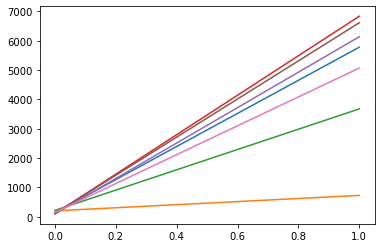

In [14]:
mean_income_by_martial_status = new_df = new_df.groupby(['income', 'marital-status'])['capital-gain'].mean().unstack()
plt.plot(mean_income_by_martial_status)

<a id="classifier"></a>
## 3. Preprocess ,Train and Evaluate a classifier

1. [Data Scaling](#3_1)
2. [Model Training: Fit SVM Model (sklearn)](#3_2)
3. [Evaluate the model](#3_3)

<a id="3_1"></a>
### 3.1. Data Scaling

Bringing features onto the same scale

<a id="3_2"></a>
### 3.2 Training a SVM via scikit-learn
Train a model using 

In [15]:
# using Support Vector Machines
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

MODEL = 'LinearSVC'
model = make_pipeline(StandardScaler(), 
                    LinearSVC(penalty='l1', C=0.001, dual=False, max_iter=1000, random_state=42))

model.fit(X_train, y_train)
print(f"model: {model}")
import sklearn
print(f"sklearn.version:{sklearn.__version__}")

model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.001, dual=False, penalty='l1',
                           random_state=42))])
sklearn.version:0.23.2


<a id="2_3"></a>
## 4. Evaluate the model

Looking at different performance evaluation metrics

https://nbviewer.jupyter.org/github/vmirly/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb

#### Reading a confusion matrix

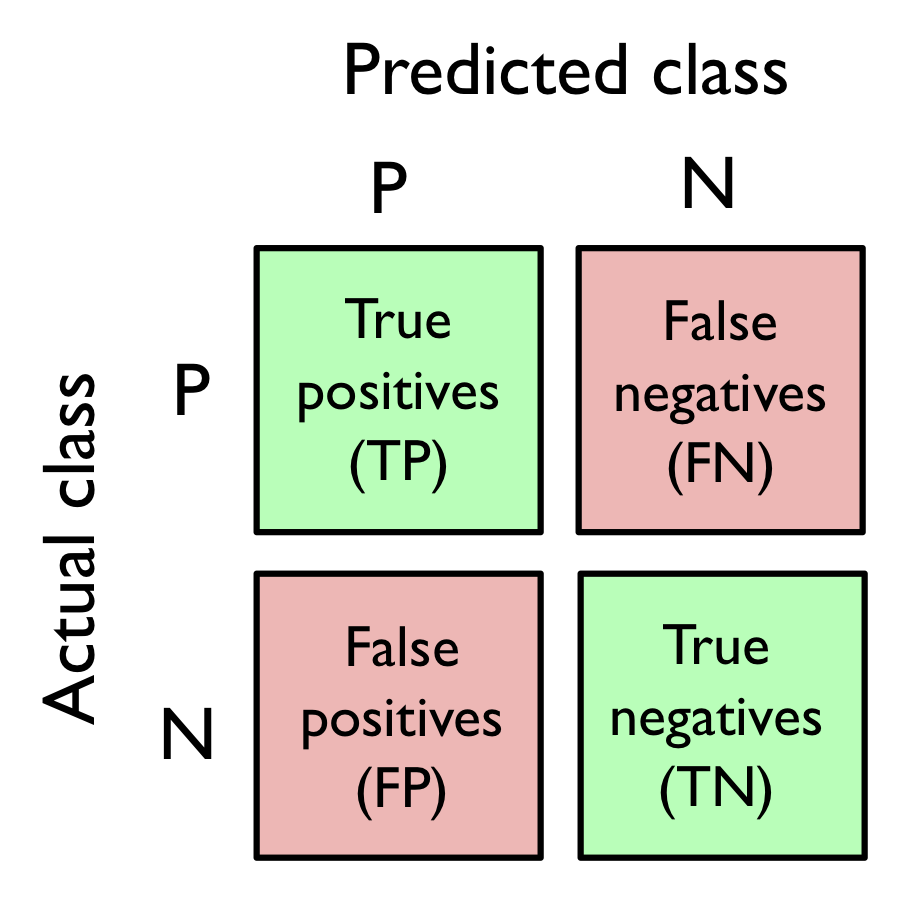

In [16]:
Image(filename='images/confusion_matrix.png', width=300) 

In [17]:
def convert_prob_to_binary(y_pred):
    # convert probabilities to binary prediction using threshold=0.5
    for i in range(0, y_pred.shape[0]):
        if y_pred[i] >= .5: # setting threshold to .5
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    return y_pred

In [18]:
# note: micro-average is preferable if you suspect there might be class imbalance
# ref: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
# Import the libraries
from sklearn import metrics

y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

y_pred = convert_prob_to_binary(y_pred)

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 
model.score(X_test, y_test)
print(f'Accuracy:{model.score(X_test, y_test)}')

# Precision
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"F1: {f1}")

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))

import joblib 
joblib.dump(model, f"models/local/{MODEL}.pkl")

prediction: [0 0 0 ... 0 0 1]
Misclassified examples:1707
confusion matrix:
 [[7229  226]
 [1481  833]]
auc: 0.6648337446169381
Accuracy: 0.8252635889036749
Accuracy:0.8252635889036749
Precision: 0.8082783402664169
Recall: 0.6648337446169381
F1: 0.6941619045147466
classification_report
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      7455
           1       0.79      0.36      0.49      2314

    accuracy                           0.83      9769
   macro avg       0.81      0.66      0.69      9769
weighted avg       0.82      0.83      0.80      9769



['models/local/LinearSVC.pkl']

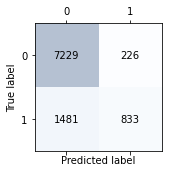

In [19]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

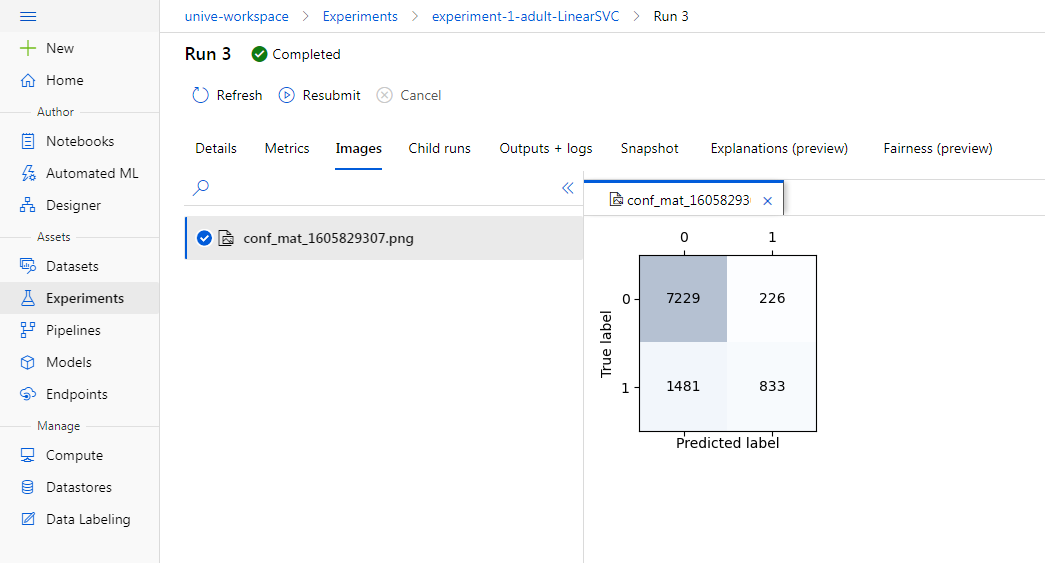

In [20]:
from IPython.display import Image

Image(filename='images/Azure/Exp-2/LinearSVC/conf_mat.png')

### Designer Metric

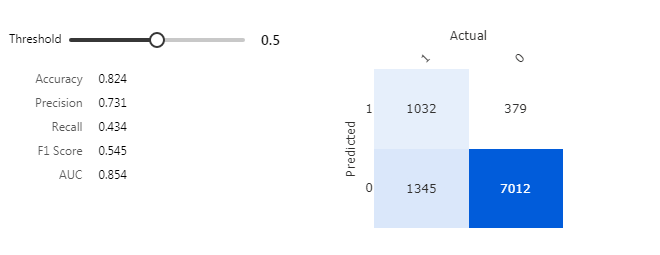

In [24]:
Image(filename='images/Azure/Exp-2/LinearSVC/designer-metrics.png')

## 4. Result comparison

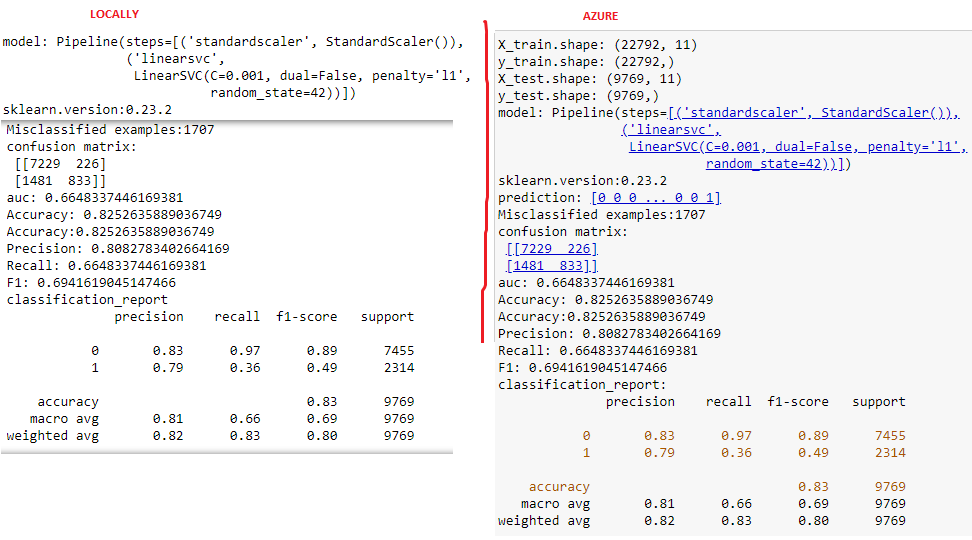

In [23]:
Image(filename='images/Azure/Exp-2/LinearSVC/result.png')

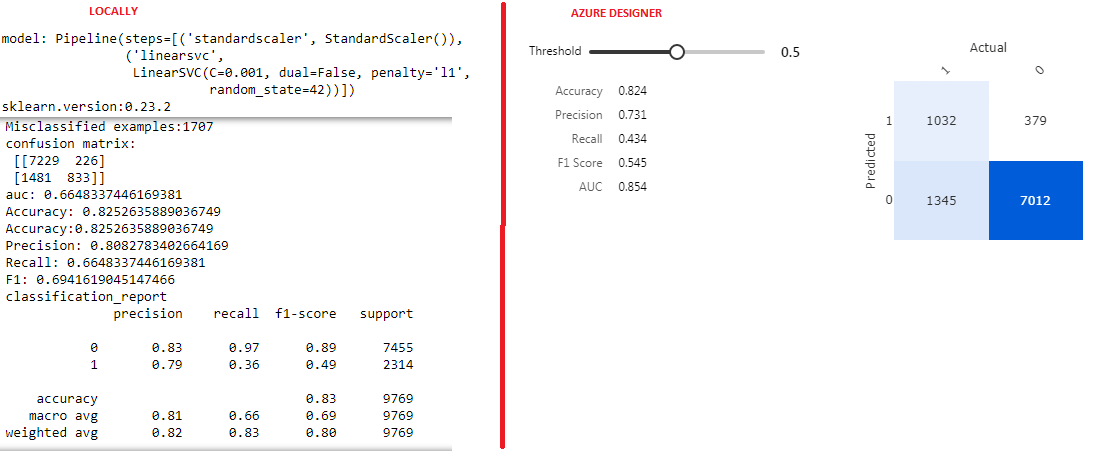

In [25]:
Image(filename='images/Azure/Exp-2/LinearSVC/result2.png')

## 5 Adversarial-Robustness-Toolbox for scikit-learn SVM

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack

#### 1 Training scikit-learn DecisionTreesClassifier and attacking with ART Zeroth Order Optimization attack

Create and apply Zeroth Order Optimization Attack with ART

Generate adversarial samples:

In [ ]:
def get_adversarial_examples(X_train, X_test, y_train):
    
    # Create and fit DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=2, random_state=42)
    model.fit(X=X_train, y=y_train)

    # Create ART classifier for scikit-learn DecisionTreeClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    X_train_adv = zoo.generate(X_train)
    X_test_adv  = zoo.generate(X_test)
    
    return X_train_adv, X_test_adv, model

## 5 Evaluate the robust classifier

Generate adversarial samples:

In [ ]:
X_train_adv, X_test_adv, model = get_adversarial_examples(X_train, X_test, y_train)

#### Evaluate DecisionTreesClassifier on benign and adversarial samples

evaluate performance on those:

1. Score
2. Predict

##### Score

In [ ]:
score = model.score(X_train, y_train)
print("Benign Training Score: %.4f" % score)

In [ ]:
score = model.score(X_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

#### Predict

In [ ]:
print(X_train[0:5, :])
prediction = model.predict(X_train[0:5, :])
print(f"Benign Training Predicted Label: {prediction}")

In [ ]:
print(X_train_adv[0:5, :])
prediction = model.predict(X_train_adv[0:5, :])
prediction
print(f"Adversarial Training Predicted Label: {prediction}")

##### Test score

In [ ]:
score = model.score(X_test, y_test)
print("Benign Test Score: %.4f" % score)

In [ ]:
print(X_test[:5, :])
prediction = model.predict(X_test[:5, :])
print(f"Benign Test Predicted Label: {prediction}")

In [ ]:
score = model.score(X_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

In [ ]:
print(X_test_adv[0:5, :])
prediction = model.predict(X_test_adv[0:5, :])
print(f"Adversarial Test Predicted Label: {prediction}")